<a id='header'></a>
# Demo for data manipulation

In this notebook we present *data manipulation* functionalities of the `preprocess` module.

- [**Section 1**](#centering_and_scaling): Centering and scaling data sets
- [**Section 2**](#outlier_detection): Multivariate outlier detection from data sets
- [**Section 3**](#kernel_density): Kernel density weighting of data sets

***

**Should plots be saved?**

In [1]:
save_plots = False

***

In [2]:
from PCAfold import preprocess
from PCAfold import PreProcessing
from PCAfold import KernelDensity
from PCAfold import reduction
import numpy as np
import random

save_filename = None

***
<a id='centering_and_scaling'></a>
## Centering and scaling and constant variable removal

[**Go up**](#header)

We begin by generating a dummy data set:

In [3]:
X = np.random.rand(100,20)

Centering and scaling can be performed in the following way:

In [4]:
(X_cs, X_center, X_scale) = preprocess.center_scale(X, 'range', nocenter=False)

Uncentering and unscaling can be performed in the following way to get back the original data set:

In [5]:
X = preprocess.invert_center_scale(X_cs, X_center, X_scale)

If constant variables are present in the data set, they can be removed using `preprocess.remove_constant_vars` function which can be a useful pre-processing before PCA is applied on a data set. Below we inject an artificial constant column to the dummy data set:

In [6]:
X[:,5] = np.ones((100,))

it can be removed by:

In [7]:
(X_removed, idx_removed, idx_retained) = preprocess.remove_constant_vars(X)

Indices of any removed columns are stored in the `idx_removed` vector:

In [8]:
idx_removed

[5]

In addition to that, an object of the `PreProcessing` class can be created and used to store the combination of the above pre-processing:

In [9]:
preprocessed = preprocess.PreProcessing(X, 'range', nocenter=False)

Centered and scaled data set can then be accessed as class attribute:

In [10]:
preprocessed.X_cs

array([[ 5.67711355e-02, -3.68283186e-01, -4.41822967e-01, ...,
         7.29259974e-02, -7.62791005e-02, -2.98527929e-02],
       [-5.28342214e-02,  8.11173599e-02,  2.62105348e-01, ...,
        -1.77575172e-01,  1.46044323e-01,  2.54740739e-01],
       [-3.36403282e-03, -2.05503976e-01,  3.10523110e-01, ...,
         2.35868575e-01,  3.24459735e-01, -1.80158201e-01],
       ...,
       [-3.13214655e-01,  4.95680546e-02, -3.94085954e-05, ...,
        -2.46754354e-01, -2.47583321e-01, -4.58973853e-01],
       [ 8.48789207e-02, -3.22246642e-01, -3.70591551e-01, ...,
         1.20041194e-01, -3.49412657e-01, -1.10764838e-01],
       [ 8.70965853e-02, -9.80804144e-02, -2.57693125e-01, ...,
        -3.75313083e-01, -4.80023409e-01, -2.48426938e-01]])

as well as the corresponding centers and scales:

In [11]:
preprocessed.X_center

array([0.50138598, 0.48105152, 0.49597835, 0.54190773, 0.47183269,
       0.50746763, 0.53707746, 0.53222549, 0.52466801, 0.5022522 ,
       0.51438108, 0.54421197, 0.52080103, 0.47061219, 0.5134684 ,
       0.50653431, 0.51198284, 0.48573183, 0.46599298])

In [12]:
preprocessed.X_scale

array([0.99633696, 0.96472381, 0.98840219, 0.9643334 , 0.99299238,
       0.98941393, 0.98255633, 0.97420893, 0.99103893, 0.98664482,
       0.97308301, 0.98420996, 0.96691423, 0.95298389, 0.96674154,
       0.95766947, 0.98246154, 0.9940613 , 0.98263424])

***
<a id='outlier_detection'></a>
## Multivariate outlier detection

[**Go up**](#header)

Genrate a two-dimensional data set with artificial outliers:

In [13]:
N = 2000
mean = [3, 3]
covariance = [[1, 0.2], [0.2, 1]]
x_data, y_data = np.random.multivariate_normal(mean, covariance, N).T

N_outliers = 20
mean_outliers = [7, 10]
covariance_outliers = [[0.2, .1], [.1, 0.2]]
x_outliers, y_outliers = np.random.multivariate_normal(mean_outliers, covariance_outliers, N_outliers).T

idx = np.zeros((N+N_outliers,))
x = np.vstack((x_data[:,np.newaxis], x_outliers[:,np.newaxis]))
y = np.vstack((y_data[:,np.newaxis], y_outliers[:,np.newaxis]))
X = np.hstack((x, y))

(n_observations, n_variables) = np.shape(X)

Visualize the data set and outliers using the `preprocess.plot_2d_clustering` function. Cluster `"0"` will be the data set and cluster `"1"` will be the outliers:

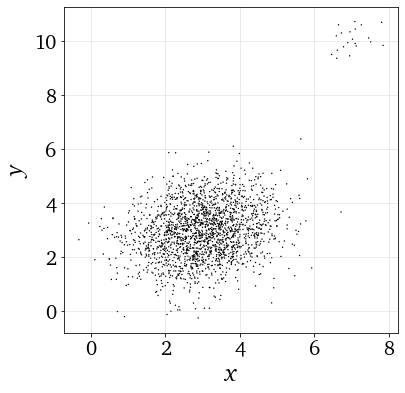

In [14]:
if save_plots: save_filename = '../images/data-manipulation-initial-data'
plt = reduction.plot_2d_manifold(X, color_variable='k', x_label='$x$', y_label='$y$', colorbar_label=None, title=None, save_filename=save_filename)

### Find multivariate outliers using `MULTIVARIATE TRIMMING` option

In [15]:
(idx_outliers_removed, idx_outliers) = preprocess.outlier_detection(X, scaling='auto', method='MULTIVARIATE TRIMMING', trimming_threshold=0.6, verbose=True)

Number of observations classified as outliers: 20


We are going to visualize how the algorithm classified the data into outliers/not-outliers. We begin by generating the new cluster classification vector, where the cluster $k_0$ will be non-outliers and cluster $k_1$ will be outliers:

In [16]:
idx_new = np.zeros((n_observations,))
for i in range(0, n_observations):
    if i in idx_outliers:
        idx_new[i] = 1

We can plot the partitioning:

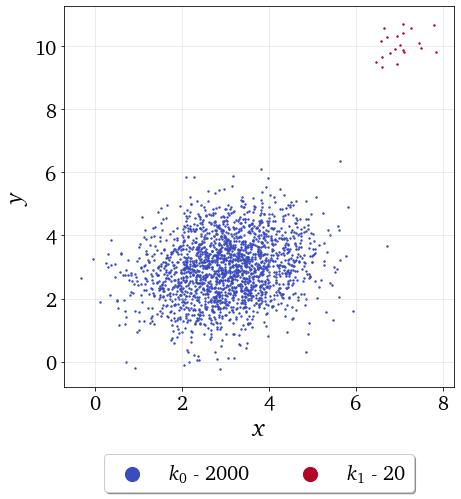

In [17]:
if save_plots: save_filename = '../images/data-manipulation-outliers-multivariate-trimming-60'
plt = preprocess.plot_2d_clustering(x, y, idx_new, x_label='$x$', y_label='$y$', color_map='coolwarm', first_cluster_index_zero=True, grid_on=True, figure_size=(7, 7), title=None, save_filename=save_filename)

If the parameter `trimming_threshold` is decreased, we more points that are within the data cloud become classified as outliers:

In [18]:
(idx_outliers_removed, idx_outliers) = preprocess.outlier_detection(X, scaling='auto', method='MULTIVARIATE TRIMMING', trimming_threshold=0.3, verbose=True)

Number of observations classified as outliers: 149


In [19]:
idx_new = np.zeros((n_observations,))
for i in range(0, n_observations):
    if i in idx_outliers:
        idx_new[i] = 1

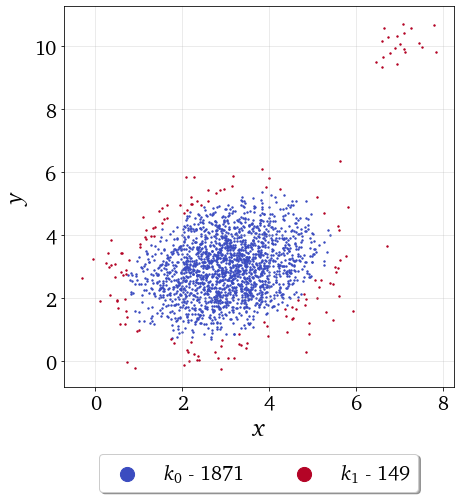

In [20]:
if save_plots: save_filename = '../images/data-manipulation-outliers-multivariate-trimming-30'
plt = preprocess.plot_2d_clustering(x, y, idx_new, x_label='$x$', y_label='$y$', color_map='coolwarm', first_cluster_index_zero=True, grid_on=True, figure_size=(7, 7), title=None, save_filename=save_filename)

### Find multivariate outliers using `PC CLASSIFIER` option

In [21]:
(idx_outliers_removed, idx_outliers) = preprocess.outlier_detection(X, scaling='auto', method='PC CLASSIFIER', quantile_threshold=0.9899, verbose=True)

Major components that will be selected are: 1
Minor components that will be selected are: 2
Number of observations classified as outliers: 41


In [22]:
idx_new = np.zeros((n_observations,))
for i in range(0, n_observations):
    if i in idx_outliers:
        idx_new[i] = 1

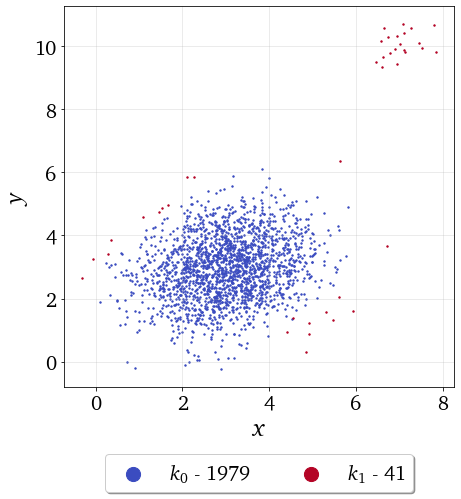

In [23]:
if save_plots: save_filename = '../images/data-manipulation-outliers-pc-classifier'
plt = preprocess.plot_2d_clustering(x, y, idx_new, x_label='$x$', y_label='$y$', color_map='coolwarm', first_cluster_index_zero=True, grid_on=True, figure_size=(7, 7), title=None, save_filename=save_filename)

***
<a id='kernel_density'></a>
## Kernel density weighting

[**Go up**](#header)

In this tutorial we reproduce results generated on a synthetic data set from the following paper:

> [Coussement, A., Gicquel, O., & Parente, A. (2012). Kernel density weighted principal component analysis of combustion processes. Combustion and flame, 159(9), 2844-2855.](https://www.sciencedirect.com/science/article/abs/pii/S001021801200123X)

We begin by generating a synthetic data set:

In [24]:
n_observations = 2021
x1 = np.zeros((n_observations,1))
x2 = np.zeros((n_observations,1))
idx = np.zeros((n_observations,1))

for i in range(0,n_observations):
    
    R = random.random()

    if i <= 999:
        
        x1[i] = -1 + 20*R
        x2[i] = 5*x1[i] + 100*R
 
    if i >= 1000 and i <= 1020:
        
        x1[i] = 420 + 8*(i+1 - 1001)
        x2[i] = 5000/200 * (x1[i] - 400) + 500*R

    if i >= 1021 and i <= 2020:
        
        x1[i] = 1000 + 20*R
        x2[i] = 5*x1[i] + 100*R

X = np.hstack((x1, x2))

In [25]:
(X_cs, C, D) = preprocess.center_scale(X, 'auto')

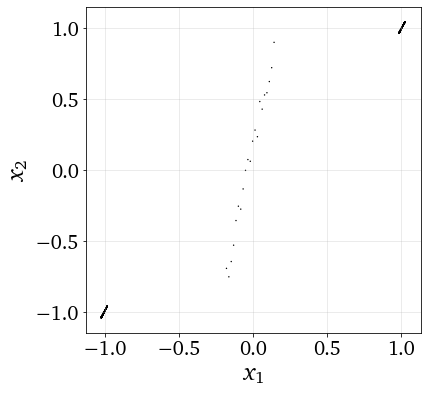

In [26]:
plt = reduction.plot_2d_manifold(X_cs, x_label='$x_1$', y_label='$x_2$')

### Single-variable case

We first compute weights using a single variable as the conditioning variable:

In [27]:
%time kernd_single = KernelDensity(X_cs, X_cs[:,0])

CPU times: user 17.4 s, sys: 32.6 ms, total: 17.4 s
Wall time: 17.4 s


In [28]:
X_weighted_single_variable = kernd_single.X_weighted

In [29]:
single_weights = kernd_single.weights

In [30]:
print(np.shape(single_weights))

(2021, 1)


### Multi-variable case:

In [31]:
%time kernd_multi = KernelDensity(X_cs, X_cs)

CPU times: user 36 s, sys: 131 ms, total: 36.1 s
Wall time: 36.3 s


In [32]:
X_weighted_multi_variable = kernd_multi.X_weighted

In [33]:
multi_weights = kernd_multi.weights

In [34]:
print(np.shape(multi_weights))

(2021, 1)
